In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(font_scale=1.56)
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import re
import warnings
warnings.filterwarnings('ignore')

In [138]:
path = "D:/data/Titanic data/"

df_train = pd.read_csv(path+"train.csv")
df_test = pd.read_csv(path+"test.csv")
df_all = df_train.append(df_test)

In [125]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [126]:
missing_number = df_train.isnull().sum().sort_values(ascending=False)
missing_percentage = round(df_train.isnull().sum() / df_train.isnull().count() *100, 1).sort_values(ascending=False)
missing_data = pd.concat([missing_number, missing_percentage], axis=1, keys=['Total', '%'])
missing_data[missing_data['%'] > 0]

,Total,%
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2


# Data Exploration

### Sex and Pclass

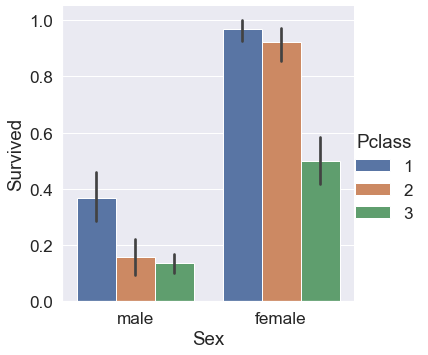

In [127]:
sns.catplot(x='Sex', y='Survived', hue='Pclass', kind='bar', data=df_train)

,Sex,Survived
0,female,0.742
1,male,0.189


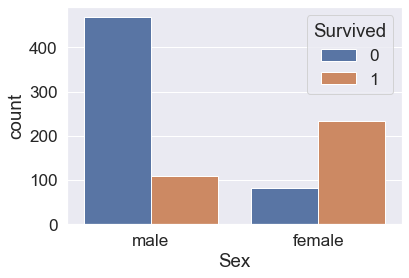

In [128]:
# Sex
sns.countplot(x='Sex', hue='Survived', data=df_train)
df_train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().round(3)

,Pclass,Survived
0,1,0.630
1,2,0.473
2,3,0.242


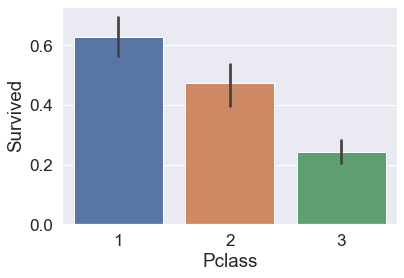

In [129]:
# Pclass
sns.barplot(x='Pclass', y='Survived', data=df_train)
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().round(3)

### Age and Sex

Text(0.5, 1.0, 'Female')

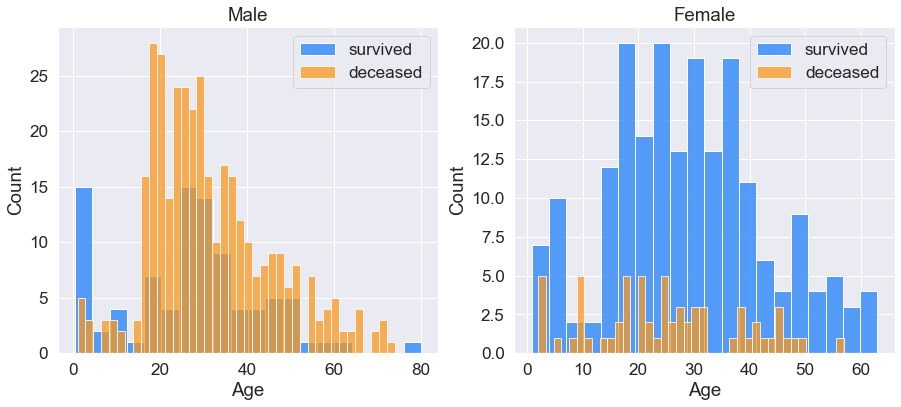

In [130]:
male_survived = df_train[(df_train['Sex']=='male') & (df_train['Survived']==1)]
male_deceased = df_train[(df_train['Sex']=='male') & (df_train['Survived']==0)]
female_survived = df_train[(df_train['Sex']=='female') & (df_train['Survived']==1)]
female_deceased = df_train[(df_train['Sex']=='female') & (df_train['Survived']==0)]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
ax = sns.histplot(male_survived['Age'].dropna(), bins=20, label = 'survived', ax=axes[0], kde=False, color='#2081f9')
ax = sns.histplot(male_deceased['Age'].dropna(), bins=40, label = 'deceased', ax=axes[0], kde=False, color='#f99820')
ax.legend()
ax.set_title('Male')

ax = sns.histplot(female_survived['Age'].dropna(), bins=20, label = 'survived', ax=axes[1], kde=False, color='#2081f9')
ax = sns.histplot(female_deceased['Age'].dropna(), bins=40, label = 'deceased', ax=axes[1], kde=False, color='#f99820')
ax.legend()
ax.set_title('Female')

### Embarked

<AxesSubplot:xlabel='Embarked', ylabel='count'>

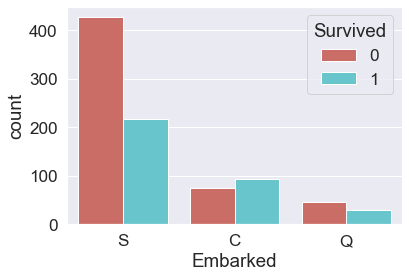

In [131]:
sns.countplot(x='Embarked', data=df_train, palette='hls', hue='Survived')

### SibSP and Parch 

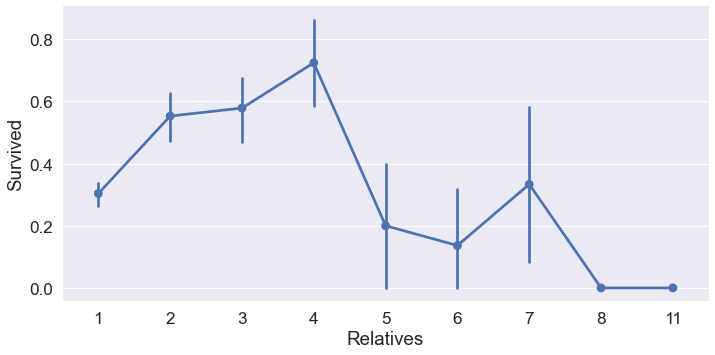

In [132]:
df_all['Relatives'] = df_all['SibSp'] + df_all['Parch'] + 1
axes = sns.factorplot(x='Relatives', y='Survived', data=df_all[:len(df_train)], aspect = 2)

### Fare

In [133]:
df_all['Fare'].fillna(df_all['Fare'].median(), inplace=True)

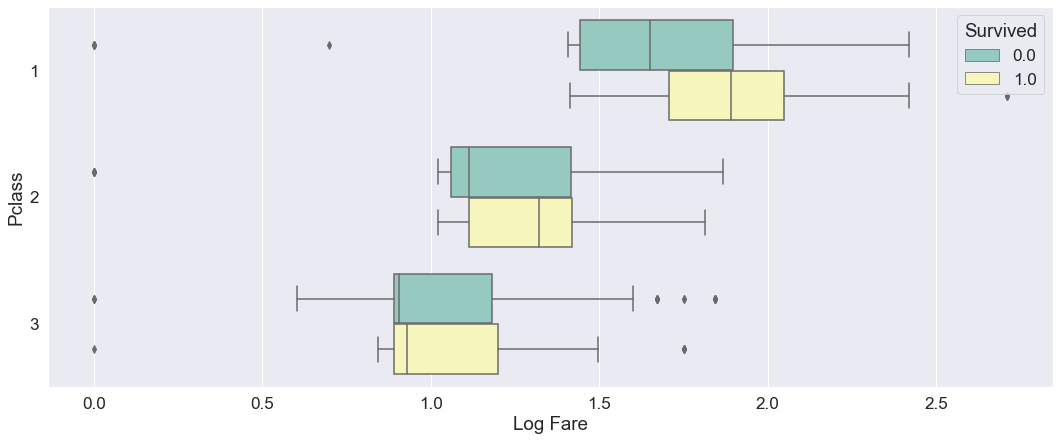

In [134]:
# Lof fare 
df_all['Log Fare'] = df_all['Fare'].map(lambda x: np.log10(x) if x > 0 else 0)

fig, ax = plt.subplots(figsize=(18,7))
sns.boxplot(y='Pclass', x='Log Fare', hue='Survived', data=df_all, orient='h',
            ax=ax, palette='Set3')
pd.pivot_table(df_all, values=['Log Fare'], index=['Pclass'], columns=['Survived'], aggfunc='median').round(3)
df_all.drop(['Log Fare'], axis=1, inplace=True)

# Data Processing

### Connected_survival

In [136]:
# Find passengers that held the same ticket
df_tk_dup = df_all[df_all.duplicated(subset=['Ticket'], keep=False)]
df_tk_dup.sort_values(['Ticket'], inplace=True)

# family or frieds
df_fam = df_tk_dup[(df_tk_dup['Relatives']>1) & (df_tk_dup['Survived'].notnull())].head(4)
df_fri = df_tk_dup[(df_tk_dup['Relatives']==1) & (df_tk_dup['Survived'].notnull())].head(4)
display(df_fam, df_fri)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Relatives
558,559,1.0,1,"Taussig, Mrs. Emil (Tillie Mandelbaum)",female,39.0,1,1,110413,79.65,E67,S,3
262,263,0.0,1,"Taussig, Mr. Emil",male,52.0,1,1,110413,79.65,E67,S,3
585,586,1.0,1,"Taussig, Miss. Ruth",female,18.0,0,2,110413,79.65,E68,S,3
366,367,1.0,1,"Warren, Mrs. Frank Manley (Anna Sophia Atkinson)",female,60.0,1,0,110813,75.25,D37,C,2


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Relatives
257,258,1.0,1,"Cherry, Miss. Gladys",female,30.0,0,0,110152,86.5,B77,S,1
504,505,1.0,1,"Maioni, Miss. Roberta",female,16.0,0,0,110152,86.5,B79,S,1
759,760,1.0,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,0,0,110152,86.5,B77,S,1
475,476,0.0,1,"Clifford, Mr. George Quincy",male,NaN,0,0,110465,52.0,A14,S,1


In [95]:
df_all['Connected_Survival'] = 0.5   # default

for tk, df_grp in df_all.groupby('Ticket'):
    if len(df_grp) > 1:
        for idx, row in df_grp.iterrows():
            gmax = df_grp.drop(idx)['Survived'].max()
            gmin = df_grp.drop(idx)['Survived'].min()
            ID = row['PassengerId']
            if gmax == 1.0:
                df_all.loc[df_all['PassengerId'] == ID, 'Connected_Survival'] = 1
            elif gmin == 0.0:
                df_all.loc[df_all['PassengerId'] == ID, 'Connected_Survival'] = 0

df_all.drop(['PassengerId', 'Ticket'], axis=1, inplace=True)
df_all.groupby('Connected_Survival')[['Survived']].mean().round(3)

,Survived
Connected_Survival,
0.0,0.225
0.5,0.298
1.0,0.728


### Deck

In [96]:
df_all['Cabin'].fillna('U', inplace=True)
sorted(df_all['Cabin'].str[0].unique())

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'U']

In [98]:
df_all.loc[df_all['Cabin'].str[0] == 'T', 'Cabin'] = 'U'

In [99]:
df_all['Deck'] = df_all['Cabin'].map(lambda x: str(x)[0]) # we only need the letter

df_all['Deck'] = df_all['Deck'].map({'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'U': 8})
df_all['Deck'] = df_all['Deck'].astype(int)

df_all.drop(['Cabin'], axis=1, inplace=True)

### Title

In [100]:
df_all['Title'] = df_all['Name'].str.extract('([A-Za-z]+)\.', expand=False)
df_all['Title'] = df_all['Title'].replace(['Don', 'Rev', 'Dr',
                                           'Major', 'Lady', 'Sir', 
                                           'Col', 'Capt', 'Countess',
                                           'Jonkheer', 'Dona'], 'Rare')
df_all['Title'] = df_all['Title'].replace(['Mme', 'Ms', 'Mlle'], 'Miss')
df_all.drop(['Name'], axis=1, inplace=True)

In [101]:
# expand=True: return dataframe
#df_all['Name'].str.extract('([A-Za-z]+)\.', expand=False).unique()

"\n# expand=True: return dataframe\ndf_all['Name'].str.extract('([A-Za-z]+)\\.', expand=False).unique()\n"

### Age

In [102]:
pd.concat([round(df_all.groupby('Title')['Age'].mean(), 1), 
           df_all.groupby('Title')['Age'].median()], 
           axis=1, keys=['mean', 'median'])

,mean,median
Title,,
Master,5.5,4.0
Miss,21.8,22.0
Mr,32.3,29.0
Mrs,37.0,35.5
Rare,45.2,47.5


In [103]:
for title in df_all.Title.unique():
    df_title = df_all[df_all['Title']==title]
    grp_mean = df_title['Age'].mean()
    grp_std = df_title['Age'].std()
    grp_isnull = df_title['Age'].isnull().sum()
    
    # compute random numbers between group mean and group standard deviation
    np.random.seed(125)
    grp_random_age = np.random.randint(grp_mean - grp_std, grp_mean + grp_std, size = grp_isnull)
    df_all.loc[(df_all['Title']==title) & (df_all['Age'].isnull()), 'Age'] = grp_random_age
    
df_all['Age'] = df_all['Age'].astype('int')   

### Embarked

In [104]:
print(df_all['Embarked'].describe())

count     1307
unique       3
top          S
freq       914
Name: Embarked, dtype: object


In [105]:
df_all['Embarked'].fillna('S', inplace=True)

# Converting Features

In [ ]:
# Sex
df_all['Sex'] = df_all['Sex'].map({'female':0, 'male':1}).astype('int')

# Fare
df_all['Fare'].fillna(df_all['Fare'].median(), inplace=True)
df_all['Fare'] = df_all['Fare'].astype(int)

# Title
df_all['Title'] = df_all['Title'].map({"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5})

# Embarked
df_all['Embarked'] = df_all['Embarked'].map({'S': 0, 'C': 1, 'Q':2})

# Creating Categories

### Age times Class

In [110]:
df_all['Age_class'] = df_all['Age']*df_all['Pclass']

### Fare Group

In [111]:
label = LabelEncoder()

df_all['Fare_grp'] = pd.qcut(df_all['Fare'], 5)
df_all['Fare_grp'] = label.fit_transform(df_all['Fare_grp'])
print(df_all['Fare_grp'].value_counts()) 

0    360
3    262
4    259
2    257
1    171
Name: Fare_grp, dtype: int64


# Spliting and Scaling

In [116]:
# convert dataframe to numpy array
ary_train = df_all.values[:len(df_train)]
ary_test = df_all.values[len(df_train):]

X_train = ary_train[:,1:]
y_train = ary_train[:,0]
X_test = ary_test[:,1:]

In [117]:
# scaling
minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1))
X_train_scaled = minmax_scale.fit_transform(X_train)
X_test_scaled = minmax_scale.fit_transform(X_test)

# MLP

In [38]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [118]:
model = Sequential()

model.add(Dense(input_dim=len(X_train[0]),
                units=40,
                kernel_initializer='uniform',
                activation='relu'))

model.add(Dense(units=30,
                kernel_initializer='uniform',
                activation='relu'))

model.add(Dense(units=1,
                kernel_initializer='uniform',
                activation='sigmoid'))

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 40)                600       
_________________________________________________________________
dense_10 (Dense)             (None, 30)                1230      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 31        
Total params: 1,861
Trainable params: 1,861
Non-trainable params: 0
_________________________________________________________________
None


In [119]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [120]:
train_history = model.fit(x=X_train_scaled,
                          y=y_train,
                          validation_split=0.1,
                          epochs=30,
                          batch_size=30,
                          verbose=2)

Epoch 1/30
27/27 - 0s - loss: 0.6888 - accuracy: 0.6130 - val_loss: 0.6807 - val_accuracy: 0.6222
Epoch 2/30
27/27 - 0s - loss: 0.6642 - accuracy: 0.6155 - val_loss: 0.6313 - val_accuracy: 0.6222
Epoch 3/30
27/27 - 0s - loss: 0.5980 - accuracy: 0.6654 - val_loss: 0.5334 - val_accuracy: 0.7778
Epoch 4/30
27/27 - 0s - loss: 0.5131 - accuracy: 0.7865 - val_loss: 0.4470 - val_accuracy: 0.8444
Epoch 5/30
27/27 - 0s - loss: 0.4487 - accuracy: 0.8340 - val_loss: 0.3936 - val_accuracy: 0.8444
Epoch 6/30
27/27 - 0s - loss: 0.4175 - accuracy: 0.8377 - val_loss: 0.3721 - val_accuracy: 0.8111
Epoch 7/30
27/27 - 0s - loss: 0.4075 - accuracy: 0.8352 - val_loss: 0.3637 - val_accuracy: 0.8222
Epoch 8/30
27/27 - 0s - loss: 0.3997 - accuracy: 0.8365 - val_loss: 0.3620 - val_accuracy: 0.8222
Epoch 9/30
27/27 - 0s - loss: 0.3964 - accuracy: 0.8414 - val_loss: 0.3623 - val_accuracy: 0.8222
Epoch 10/30
27/27 - 0s - loss: 0.3932 - accuracy: 0.8402 - val_loss: 0.3606 - val_accuracy: 0.8333
Epoch 11/30
27/27 -

In [245]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show

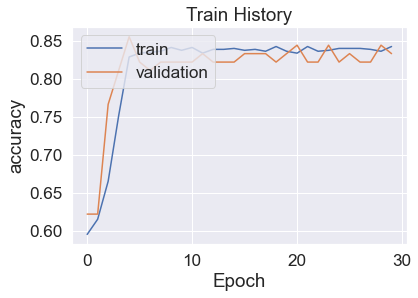

In [246]:
show_train_history(train_history, 'accuracy', 'val_accuracy')

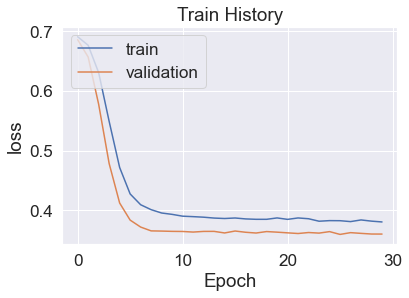

In [247]:
show_train_history(train_history, 'loss', 'val_loss')

In [121]:
df_test['Survived'] = model.predict(X_test_scaled)
df_test['Survived'] = df_test['Survived'].apply(lambda x: round(x,0)).astype('int')
solution = df_test[['PassengerId', 'Survived']]
solution.to_csv("Titanic_Neural_Network_Solution.csv", index=False)